# 02 — Crime Severity Analysis
## Canadian Crime Severity Index  (1998–2024)

Five seaborn visualisations exploring national and provincial CSI trends.

**Run `01_Data_Cleaning.ipynb` first** — or this notebook will clean from raw automatically.

Plots saved to `plots/`.

In [1]:
# ── Imports + palette + style ─────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

os.makedirs('plots', exist_ok=True)

# ── Colour palette ──
GOLD       = '#C9A84C'
GOLD_LIGHT = '#E8C97A'
GREY       = '#8B949E'
GREY_MID   = '#6E7681'
GREY_DARK  = '#30363D'
BG_FIG     = '#0D1117'
BG_AX      = '#161B22'
TEXT       = '#E6EDF3'

# ── Matplotlib base style ──
plt.rcParams.update({
    'figure.facecolor':  BG_FIG,
    'axes.facecolor':    BG_AX,
    'axes.edgecolor':    GREY_DARK,
    'axes.labelcolor':   TEXT,
    'axes.titlecolor':   TEXT,
    'xtick.color':       GREY,
    'ytick.color':       GREY,
    'text.color':        TEXT,
    'grid.color':        '#21262D',
    'grid.linestyle':    '--',
    'grid.alpha':        0.5,
    'legend.framealpha': 0,
    'legend.labelcolor': TEXT,
    'font.family':       'sans-serif',
    'figure.dpi':        150,
    'savefig.dpi':       150,
    'savefig.bbox':      'tight',
    'savefig.facecolor': BG_FIG,
})

CLEAN_PATH = '../Clean Data/crime_severity_cleaned.csv'
RAW_PATH   = '../../Raw Data/Severe Data.csv'

---
## Load & Prepare Data

In [2]:
# ── Load cleaned CSV (fall back to raw + inline cleaning) ────────────────────
try:
    df = pd.read_csv(CLEAN_PATH)
    print(f'Loaded cleaned data: {df.shape}')
except FileNotFoundError:
    df = pd.read_csv(RAW_PATH, dtype=str, encoding='utf-8')
    _drop = ['STATUS', 'SYMBOL', 'TERMINATED', 'SCALAR_FACTOR',
             'SCALAR_ID', 'UOM_ID', 'DGUID', 'COORDINATE']
    df = df.drop(columns=_drop)
    df['VALUE']    = df['VALUE'].replace({'..': np.nan, '': np.nan}).astype(float)
    df['REF_DATE'] = df['REF_DATE'].astype(int)
    df['GEO']      = df['GEO'].str.replace(r'\s*\[\d+\]', '', regex=True).str.strip()
    df = df.rename(columns={
        'REF_DATE': 'year', 'GEO': 'geography', 'Statistics': 'metric',
        'UOM': 'unit', 'VECTOR': 'vector', 'VALUE': 'value', 'DECIMALS': 'decimals',
    })
    print(f'Cleaned from raw: {df.shape}')

# ── Geography lists ──
PROVS_TERRS = [
    'Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
    'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia',
    'Nunavut', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon',
]
TERRITORIES = {'Northwest Territories', 'Nunavut', 'Yukon'}

# ── Subsets ──
csi      = df[df['metric'] == 'Crime severity index'].copy()
nat_df   = csi[csi['geography'] == 'Canada'].sort_values('year')
prov_df  = csi[csi['geography'].isin(PROVS_TERRS)].sort_values('year')

# ── Province order by 2024 CSI (descending) for charts ──
order_2024 = (
    prov_df[prov_df['year'] == 2024]
    .sort_values('value', ascending=False)['geography']
    .tolist()
)
print('Provinces ordered by 2024 CSI:', order_2024)

Loaded cleaned data: (22908, 7)
Provinces ordered by 2024 CSI: ['Northwest Territories', 'Nunavut', 'Yukon', 'Saskatchewan', 'Manitoba', 'Alberta', 'British Columbia', 'Newfoundland and Labrador', 'New Brunswick', 'Nova Scotia', 'Prince Edward Island', 'Quebec', 'Ontario']


---
## Plot 1 — National CSI Trend (1998–2024)

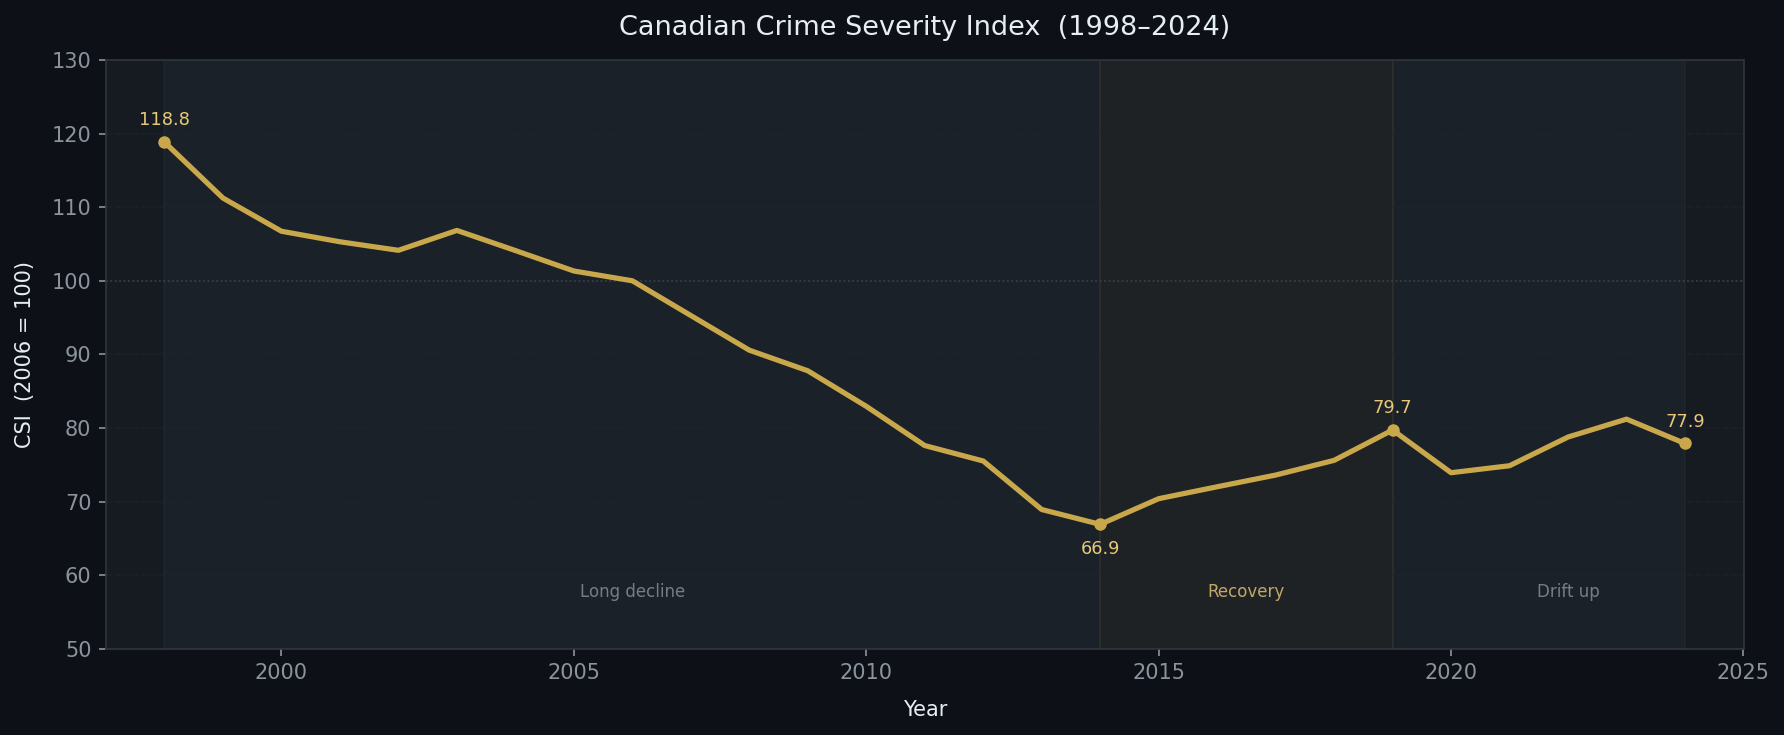

In [3]:
# ── National trend line ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))

# Phase shading
ax.axvspan(1998, 2014, alpha=0.05, color=GREY,  zorder=0)
ax.axvspan(2014, 2019, alpha=0.05, color=GOLD,  zorder=0)
ax.axvspan(2019, 2024, alpha=0.05, color=GREY,  zorder=0)

# Reference line at base year
ax.axhline(100, color=GREY_MID, linewidth=0.8, linestyle=':', alpha=0.6, zorder=1)

# Main line
sns.lineplot(data=nat_df, x='year', y='value',
             color=GOLD, linewidth=2.5, ax=ax, zorder=2)

# Dot + label for key years
key_years = {1998: 'above', 2014: 'below', 2019: 'above', 2024: 'above'}
for yr, pos in key_years.items():
    row = nat_df[nat_df['year'] == yr]
    if row.empty:
        continue
    val = row['value'].values[0]
    ax.plot(yr, val, 'o', color=GOLD, markersize=5, zorder=3)
    offset = 8 if pos == 'above' else -14
    ax.annotate(f'{val:.1f}', xy=(yr, val),
                xytext=(0, offset), textcoords='offset points',
                ha='center', fontsize=8.5, color=GOLD_LIGHT)

# Phase labels
ax.text(2006,  57, 'Long decline', ha='center', fontsize=8, color=GREY,     alpha=0.8)
ax.text(2016.5,57, 'Recovery',     ha='center', fontsize=8, color=GOLD_LIGHT,alpha=0.8)
ax.text(2022,  57, 'Drift up',     ha='center', fontsize=8, color=GREY,     alpha=0.8)

ax.set_title('Canadian Crime Severity Index  (1998–2024)',
             fontsize=13, pad=12)
ax.set_xlabel('Year', labelpad=8)
ax.set_ylabel('CSI  (2006 = 100)', labelpad=8)
ax.set_xlim(1997, 2025)
ax.set_ylim(50, 130)
ax.grid(True, axis='y')

plt.tight_layout()
plt.savefig('plots/01_national_trend.png')
plt.show()

---
## Plot 2 — Provincial & Territorial Trends (Small Multiples)

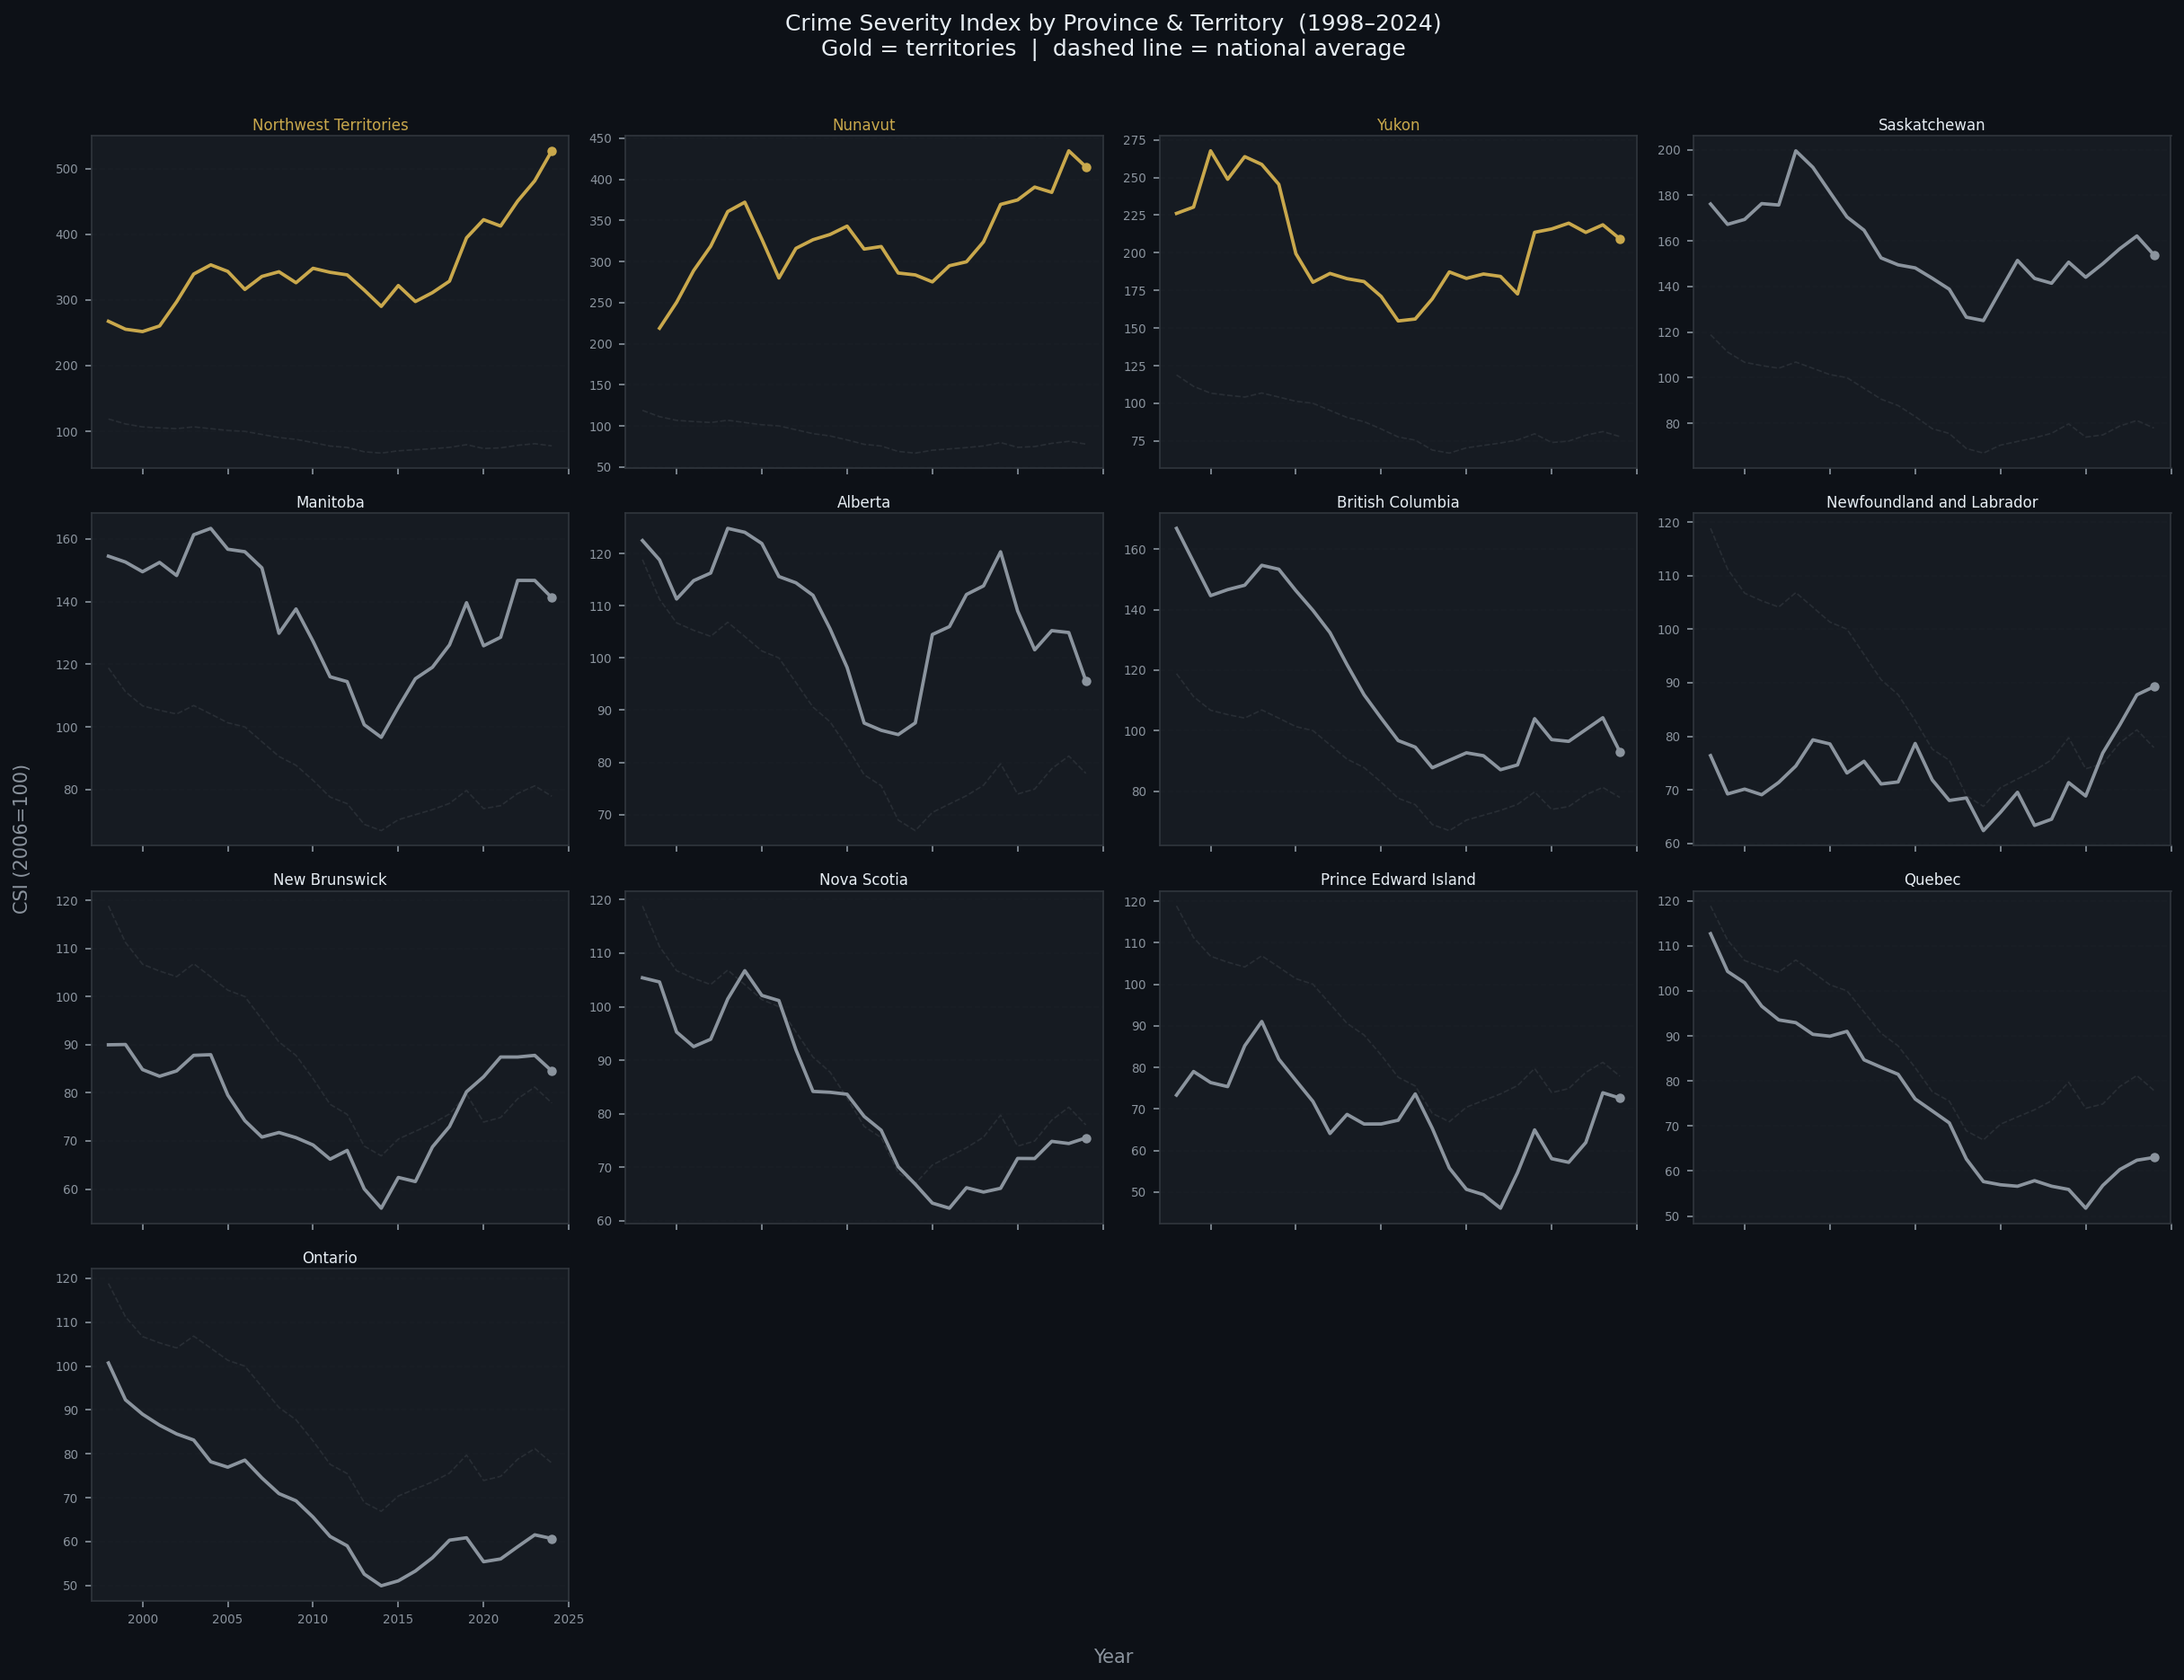

In [4]:
# ── Small multiples — one panel per province/territory ───────────────────────
NCOLS, NROWS = 4, 4
fig, axes = plt.subplots(NROWS, NCOLS, figsize=(16, 12),
                          facecolor=BG_FIG, sharex=True)
fig.suptitle('Crime Severity Index by Province & Territory  (1998–2024)\n'
             'Gold = territories  |  dashed line = national average',
             fontsize=12, color=TEXT, y=1.01)

axes_flat = axes.flatten()
nat_yr    = nat_df.set_index('year')['value']

for i, geo in enumerate(order_2024):
    ax  = axes_flat[i]
    sub = prov_df[prov_df['geography'] == geo].sort_values('year')
    lc  = GOLD if geo in TERRITORIES else GREY
    tc  = GOLD if geo in TERRITORIES else TEXT

    # National average reference
    ax.plot(nat_yr.index, nat_yr.values,
            color=GREY_DARK, linewidth=0.8, linestyle='--', alpha=0.7, zorder=1)

    # Province / territory line
    sns.lineplot(data=sub, x='year', y='value',
                 color=lc, linewidth=1.8, ax=ax, zorder=2)

    # 2024 endpoint dot
    end = sub[sub['year'] == 2024]
    if not end.empty:
        ax.plot(2024, end['value'].values[0], 'o', color=lc, markersize=4, zorder=3)

    ax.set_facecolor(BG_AX)
    ax.set_title(geo, fontsize=8, pad=3, color=tc)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=6.5, colors=GREY)
    for spine in ax.spines.values():
        spine.set_edgecolor(GREY_DARK)
    ax.grid(True, axis='y', alpha=0.3, color='#21262D')
    ax.set_xlim(1997, 2025)

# Hide unused panels
for j in range(len(order_2024), len(axes_flat)):
    axes_flat[j].set_visible(False)

fig.text(0.5,  -0.01, 'Year',          ha='center', color=GREY, fontsize=10)
fig.text(-0.01, 0.5,  'CSI (2006=100)', va='center', color=GREY, fontsize=10,
         rotation='vertical')

plt.tight_layout()
plt.savefig('plots/02_provincial_trends.png', bbox_inches='tight')
plt.show()

---
## Plot 3 — 2024 CSI Rankings

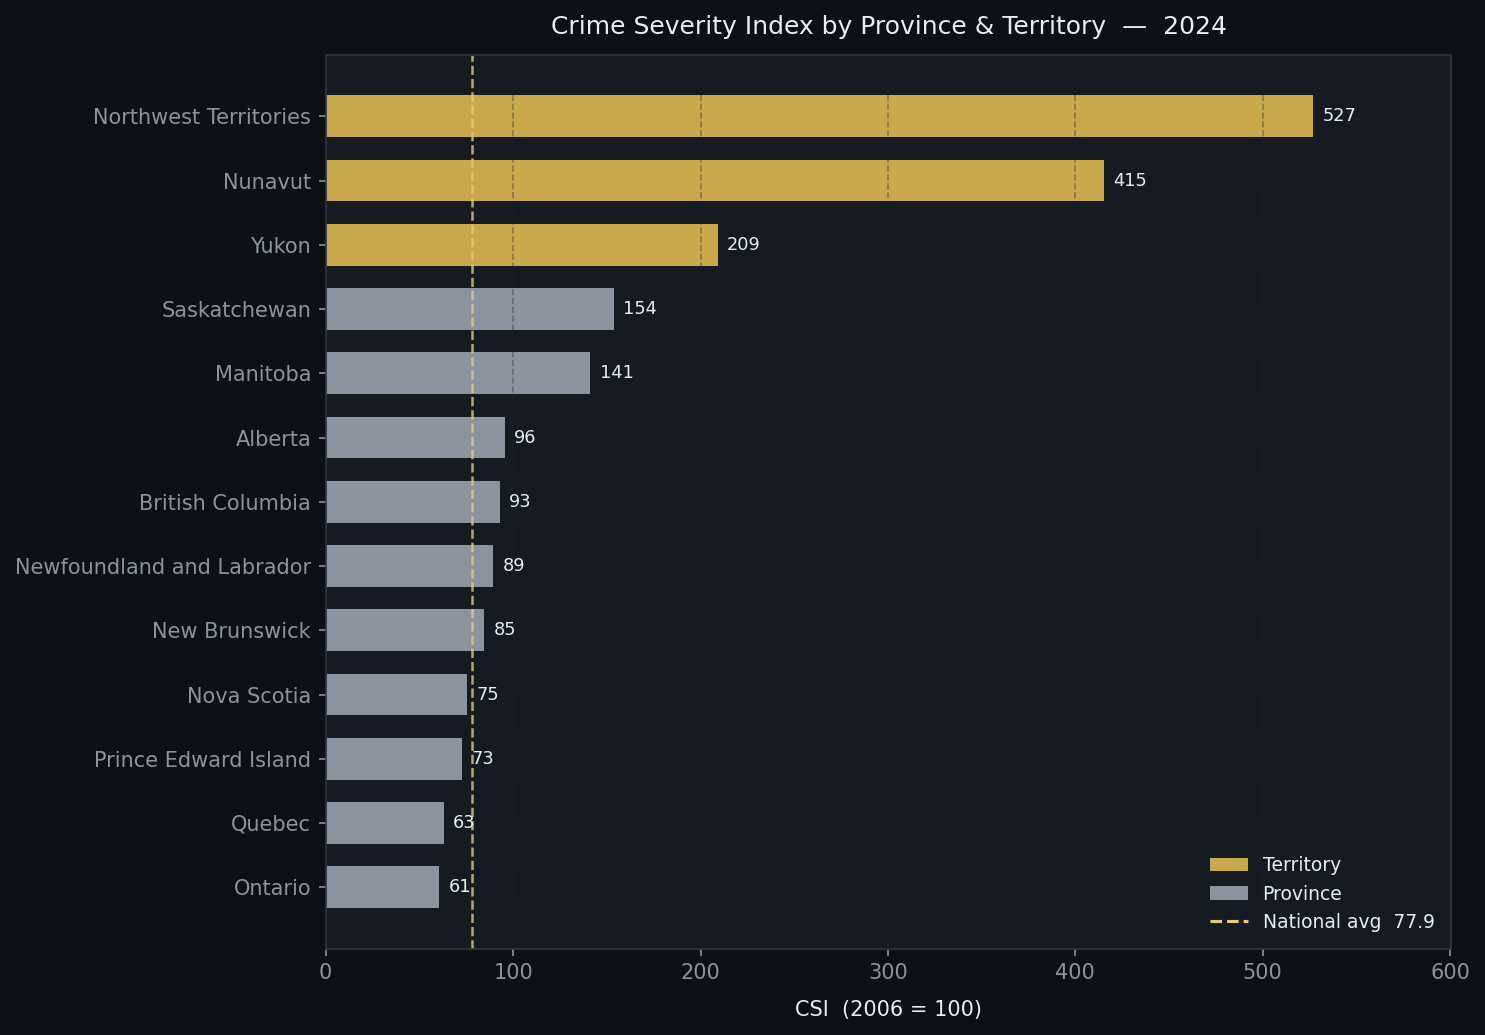

In [5]:
# ── Horizontal bar — 2024 rankings ───────────────────────────────────────────
rank_df = (
    prov_df[prov_df['year'] == 2024]
    .sort_values('value', ascending=True)
    .reset_index(drop=True)
)
nat_2024 = nat_df[nat_df['year'] == 2024]['value'].values[0]
bar_colors = [GOLD if g in TERRITORIES else GREY for g in rank_df['geography']]

fig, ax = plt.subplots(figsize=(10, 7))

bars = ax.barh(rank_df['geography'], rank_df['value'],
               color=bar_colors, edgecolor='none', height=0.65)

# Value labels
for bar, val in zip(bars, rank_df['value']):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2,
            f'{val:.0f}', va='center', fontsize=8.5, color=TEXT)

# National average line
ax.axvline(nat_2024, color=GOLD_LIGHT, linewidth=1.2, linestyle='--', alpha=0.8,
           label=f'National avg  {nat_2024:.1f}')

ax.set_title('Crime Severity Index by Province & Territory  —  2024',
             fontsize=12, pad=10)
ax.set_xlabel('CSI  (2006 = 100)', labelpad=8)
ax.set_xlim(0, rank_df['value'].max() * 1.14)
ax.legend(fontsize=9)
ax.grid(True, axis='x', alpha=0.4)

legend_handles = [
    mpatches.Patch(facecolor=GOLD, label='Territory'),
    mpatches.Patch(facecolor=GREY, label='Province'),
]
ax.legend(handles=legend_handles +
          [plt.Line2D([0], [0], color=GOLD_LIGHT, linestyle='--',
                      label=f'National avg  {nat_2024:.1f}')],
          fontsize=9)

plt.tight_layout()
plt.savefig('plots/03_2024_rankings.png')
plt.show()

---
## Plot 4 — Change in CSI from Baseline to 2024

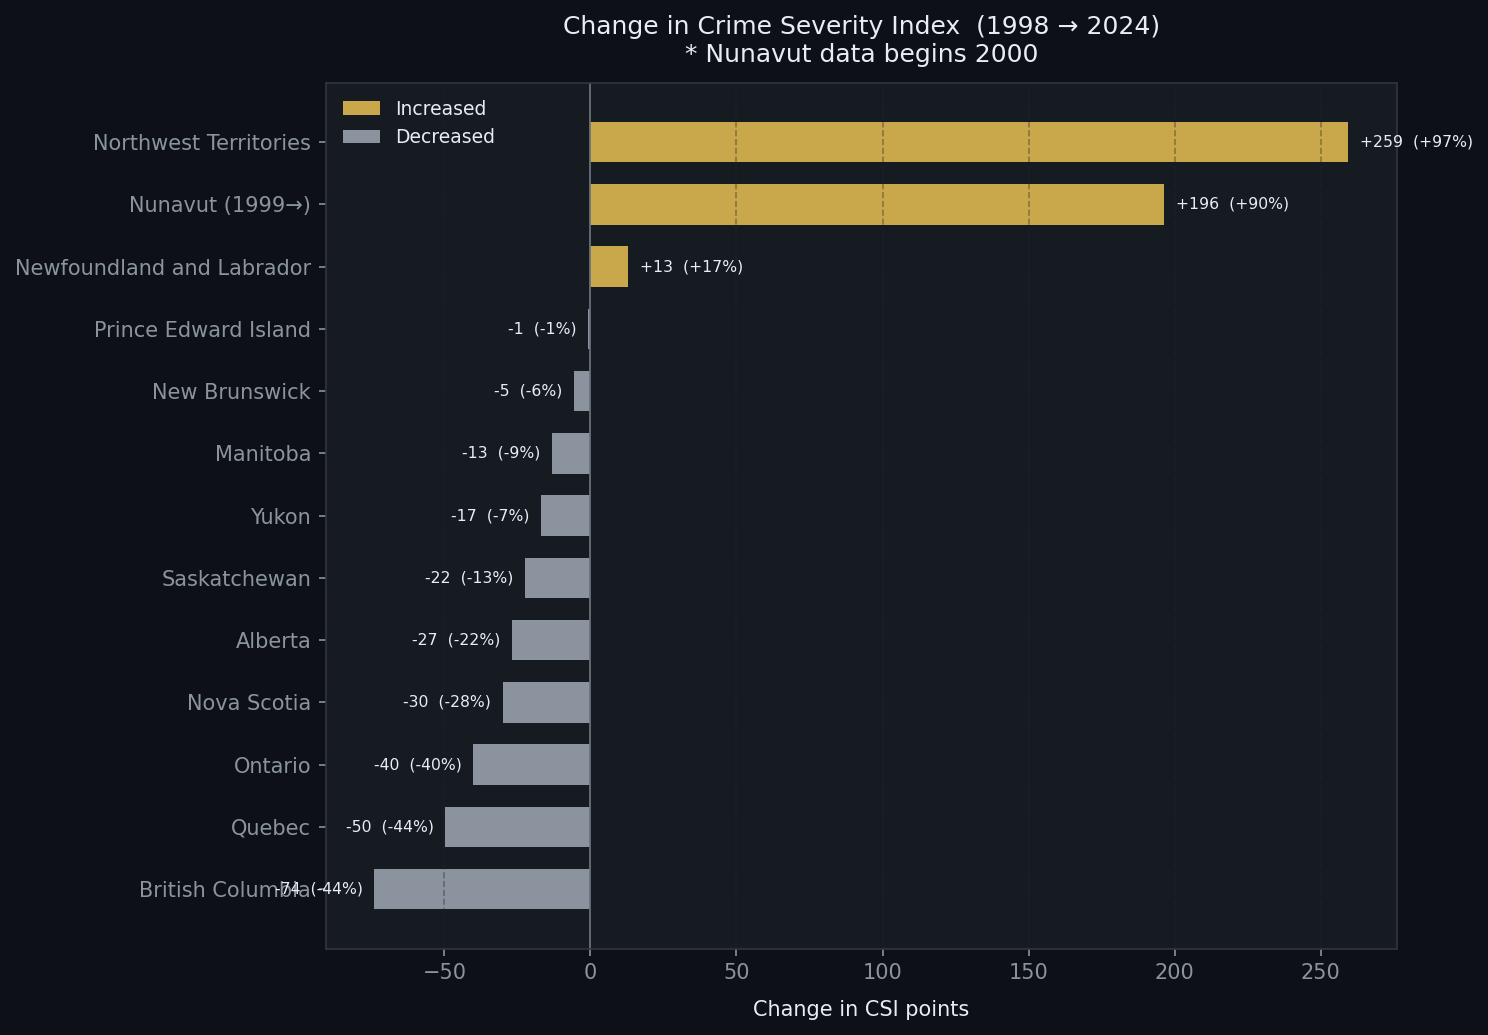

In [6]:
# ── Diverging bar — change from earliest available year to 2024 ───────────────
rows = []
for geo in PROVS_TERRS:
    sub = prov_df[prov_df['geography'] == geo].sort_values('year')
    if sub.empty:
        continue
    end_row = sub[sub['year'] == 2024]
    if end_row.empty:
        continue
    # Prefer 1998; fall back to earliest available
    start_row = sub[sub['year'] == 1998]
    if start_row.empty:
        start_row = sub.iloc[[0]]
    start_yr = int(start_row['year'].values[0])
    v_start  = start_row['value'].values[0]
    v_end    = end_row['value'].values[0]
    label    = geo if start_yr == 1998 else f'{geo} ({start_yr}→)'
    rows.append({'geography': geo, 'label': label,
                 'change': v_end - v_start, 'pct': (v_end - v_start) / v_start * 100})

chg = pd.DataFrame(rows).sort_values('change', ascending=True)
bar_colors = [GOLD if c > 0 else GREY for c in chg['change']]

fig, ax = plt.subplots(figsize=(10, 7))

bars = ax.barh(chg['label'], chg['change'],
               color=bar_colors, edgecolor='none', height=0.65)

# Value labels
for bar, (_, row) in zip(bars, chg.iterrows()):
    x_off = 4  if row['change'] >= 0 else -4
    ha    = 'left' if row['change'] >= 0 else 'right'
    ax.text(bar.get_width() + x_off, bar.get_y() + bar.get_height() / 2,
            f"{row['change']:+.0f}  ({row['pct']:+.0f}%)",
            va='center', ha=ha, fontsize=7.5, color=TEXT)

ax.axvline(0, color=GREY_MID, linewidth=0.8)
ax.set_title('Change in Crime Severity Index  (1998 → 2024)\n'
             '* Nunavut data begins 2000',
             fontsize=12, pad=10)
ax.set_xlabel('Change in CSI points', labelpad=8)
ax.grid(True, axis='x', alpha=0.4)

legend_handles = [
    mpatches.Patch(facecolor=GOLD, label='Increased'),
    mpatches.Patch(facecolor=GREY, label='Decreased'),
]
ax.legend(handles=legend_handles, fontsize=9)

plt.tight_layout()
plt.savefig('plots/04_change_1998_2024.png')
plt.show()

---
## Plot 5 — Violent vs Non-Violent CSI (National)

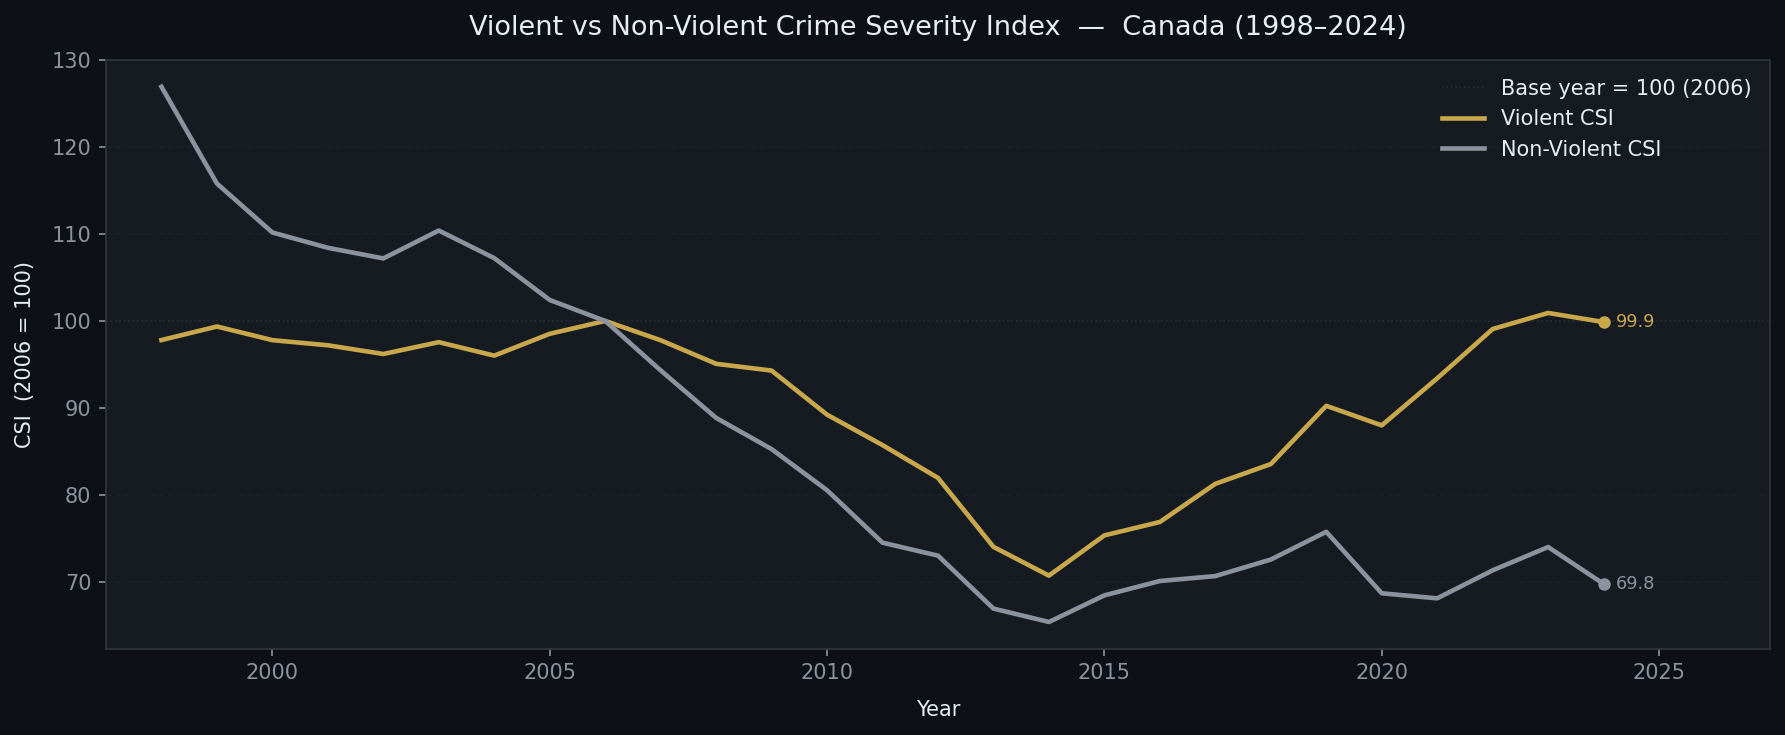

In [7]:
# ── Violent vs non-violent national comparison ────────────────────────────────
violent    = df[(df['metric'] == 'Violent crime severity index') &
                (df['geography'] == 'Canada')].sort_values('year')
nonviolent = df[(df['metric'] == 'Non-violent crime severity index') &
                (df['geography'] == 'Canada')].sort_values('year')

fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(100, color=GREY_DARK, linewidth=0.8, linestyle=':', alpha=0.6,
           label='Base year = 100 (2006)')

sns.lineplot(data=violent,    x='year', y='value',
             color=GOLD, linewidth=2.2, label='Violent CSI',     ax=ax)
sns.lineplot(data=nonviolent, x='year', y='value',
             color=GREY, linewidth=2.2, label='Non-Violent CSI', ax=ax)

# Endpoint labels
for data, lbl, color in [(violent, 'Violent', GOLD), (nonviolent, 'Non-Violent', GREY)]:
    end = data[data['year'] == 2024]
    if not end.empty:
        val = end['value'].values[0]
        ax.plot(2024, val, 'o', color=color, markersize=5)
        ax.annotate(f'{val:.1f}', xy=(2024, val),
                    xytext=(6, 0), textcoords='offset points',
                    va='center', fontsize=8.5, color=color)

ax.set_title('Violent vs Non-Violent Crime Severity Index  —  Canada (1998–2024)',
             fontsize=13, pad=12)
ax.set_xlabel('Year', labelpad=8)
ax.set_ylabel('CSI  (2006 = 100)', labelpad=8)
ax.set_xlim(1997, 2027)
ax.legend(fontsize=10)
ax.grid(True, axis='y')

plt.tight_layout()
plt.savefig('plots/05_violent_nonviolent.png')
plt.show()